Fundamentos de ciência de dados - Luiz Davi e Thiago Cavalcanti

In [83]:
from nba_api_jogadores_utils import obter_logs_dos_jogos_por_jogador
from constantes_jogadores import DICIONARIO_JOGADORES, TEMPORADA_ATUAL, RESULTADOS_PATH
import pandas as pd
import numpy as np

# Regressão logística: variável alvo

## RF5 – Possível uso  de variáveis independentes:  tempo que o jogador passou em quadra, arremessos tentados e turnovers. Variáveis dependentes, pontos, assistências e rebotes. Divida os dados de teste e treinamento.

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Coletando os dados

In [74]:
lista_de_dataframes = []
for nome, id in DICIONARIO_JOGADORES.items():
    dados = obter_logs_dos_jogos_por_jogador(id, TEMPORADA_ATUAL)
    dados = dados[['GAME_DATE', 'MIN', 'FGA', 'TOV', 'PTS', 'AST', 'REB']]
    dados['PLAYER'] = nome
    lista_de_dataframes.append(dados)

In [75]:
dataframe_nba = pd.concat(lista_de_dataframes)
dataframe_nba.columns = ['Data', 'Minutos', 'Arremessos', 'Turnovers', 'Pontos', 'Assistências', 'Rebotes', 'Jogador']

dataframe_nba.head()

,Data,Minutos,Arremessos,Turnovers,Pontos,Assistências,Rebotes,Jogador
0,"FEB 03, 2025",36,13,1,27,10,14,Nikola Jokić
1,"FEB 01, 2025",37,17,4,28,17,13,Nikola Jokić
2,"JAN 31, 2025",37,16,6,28,13,9,Nikola Jokić
3,"JAN 29, 2025",33,15,2,17,6,6,Nikola Jokić
4,"JAN 27, 2025",40,21,4,33,14,12,Nikola Jokić


Selecionando variáveis independentes e dependentes

In [97]:
dataframe_nba['Pontos_acima_media'] = (dataframe_nba['Pontos'] > dataframe_nba['Pontos'].mean()).astype(int)
dataframe_nba['Assistencias_acima_media'] = (dataframe_nba['Assistências'] > dataframe_nba['Assistências'].mean()).astype(int)
dataframe_nba['Rebotes_acima_media'] = (dataframe_nba['Rebotes'] > dataframe_nba['Rebotes'].mean()).astype(int)

Treinando o modelo e fazendo previsões

In [77]:
def treinar_modelo_regressao_logistica(y_label):
    X = dataframe_nba[['Minutos', 'Arremessos', 'Turnovers']]
    y = dataframe_nba[y_label]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

    modelo = LogisticRegression()
    modelo.fit(X_treino, y_treino)

    # Fazer previsões
    y_pred = modelo.predict(X_teste)
    y_prob = modelo.predict_proba(X_teste)[:, 1]  # Probabilidades da classe 1

    return X_teste, y_teste, y_pred, y_prob, modelo

In [78]:
X_teste_pontos, y_teste_pontos, y_pred_pontos, y_prob_pontos, modelo_pontos = treinar_modelo_regressao_logistica('Pontos_acima_media')
X_teste_assistencias, y_teste_assistencias, y_pred_assistencias, y_prob_assistencias, modelo_assistencias = treinar_modelo_regressao_logistica('Assistencias_acima_media')
X_teste_rebotes, y_teste_rebotes, y_pred_rebotes, y_prob_rebotes, modelo_rebotes = treinar_modelo_regressao_logistica('Rebotes_acima_media')

### As probabilidades de o jogador marcar acima e abaixo da média, mediana, moda, máximo e mínimo para pontos, rebotes e assistências.

#### Pontos

In [79]:
resultados_pontos = X_teste_pontos.copy()
resultados_pontos['Probabilidade_acima_media_pontos'] = y_prob_pontos
resultados_pontos['Previsao'] = y_pred_pontos
resultados_pontos['Real'] = y_teste_pontos.values

resultados_pontos.head()

,Minutos,Arremessos,Turnovers,Probabilidade_acima_media_pontos,Previsao,Real
45,39,18,3,0.659226,1,1
11,37,26,5,0.991383,1,1
12,38,21,1,0.839953,1,1
26,39,39,5,0.999980,1,1
20,34,14,1,0.162446,0,1


#### Assistências

In [96]:
resultados_assistencias = X_teste_assistencias.copy()
resultados_assistencias['Probabilidade_acima_media_assistências'] = y_prob_assistencias
resultados_assistencias['Previsao'] = y_pred_assistencias
resultados_assistencias['Real'] = y_teste_assistencias.values

resultados_assistencias.head()

,Minutos,Arremessos,Turnovers,Probabilidade_acima_media_assistências,Previsao,Real
45,39,18,3,0.558331,1,0
11,37,26,5,0.811879,1,0
12,38,21,1,0.428491,0,1
26,39,39,5,0.926881,1,1
20,34,14,1,0.269599,0,0


#### Rebotes

In [81]:
resultados_rebotes = X_teste_rebotes.copy()
resultados_rebotes['Probabilidade_acima_media_rebotes'] = y_prob_rebotes
resultados_rebotes['Previsao'] = y_pred_rebotes
resultados_rebotes['Real'] = y_teste_rebotes.values

resultados_rebotes.head()

,Minutos,Arremessos,Turnovers,Probabilidade_acima_media_rebotes,Previsao,Real
45,39,18,3,0.506046,1,0
11,37,26,5,0.726518,1,0
12,38,21,1,0.441285,0,1
26,39,39,5,0.882933,1,1
20,34,14,1,0.285707,0,0


## RF6 –  Apresente gráficos que facilitem a interpretação das previsões como matriz de confusão, gráficos de probabilidade predita, curva roc, gráficos de coeficientes, etc. 

In [84]:
import os
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [85]:
def exportar_grafico(nome_arquivo):
    caminho_destino = f'{RESULTADOS_PATH}/graficos'
    os.makedirs(caminho_destino, exist_ok=True)

    caminho_arquivo = os.path.join(caminho_destino, nome_arquivo)
    plt.savefig(caminho_arquivo, dpi=300, bbox_inches='tight')

### Matriz de confusão

In [87]:
def plotar_matriz_de_confusao(y_teste, y_pred, estatistica_analisada):
    matriz_de_confusao = confusion_matrix(y_teste, y_pred)

    sns.heatmap(matriz_de_confusao, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.title(f'Matriz de confusão - Previsão de {estatistica_analisada} acima/abaixo da média')

    exportar_grafico(f'matriz_confusao_{estatistica_analisada}_regressao_logistica.png')

    plt.show()

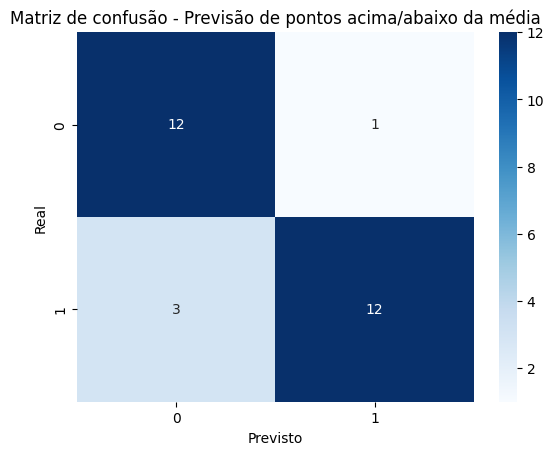

In [88]:
plotar_matriz_de_confusao(y_teste_pontos, y_pred_pontos, 'pontos')

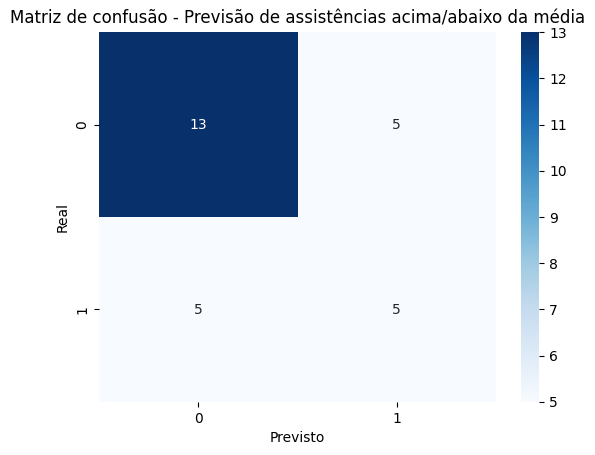

In [90]:
plotar_matriz_de_confusao(y_teste_assistencias, y_pred_assistencias, 'assistências')

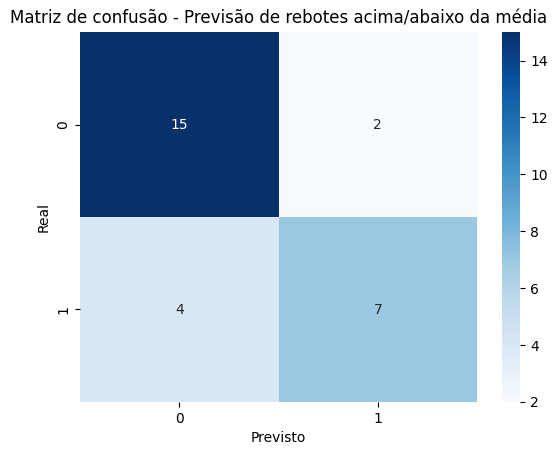

In [91]:
plotar_matriz_de_confusao(y_teste_rebotes, y_pred_rebotes, 'rebotes')

### Gráficos de probabilidade (histogramas de distribuição - real vs previsto)

In [100]:
def plotar_distribuicao_probabilidades(resultados, estatistica_analisada):
    sns.histplot(resultados[f'Probabilidade_acima_media_{estatistica_analisada.lower()}'], bins=10, kde=True)
    plt.title(f'Distribuição das probabilidades previstas - {estatistica_analisada}')
    plt.xlabel('Probabilidade de marcar acima da média')
    plt.ylabel('Frequência')

    exportar_grafico(f'probabilidade_{estatistica_analisada}_regressao_logistica.png')

    plt.show()

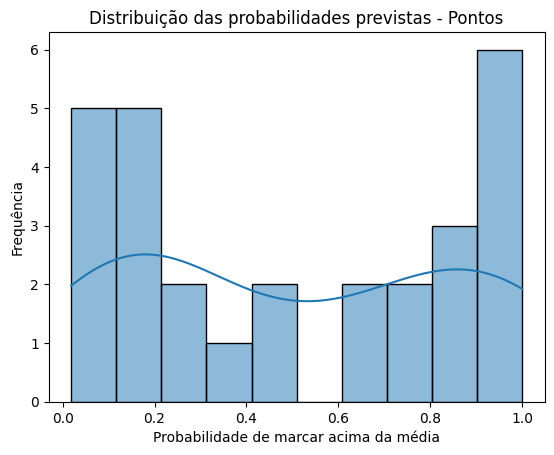

In [101]:
plotar_distribuicao_probabilidades(resultados_pontos, 'Pontos')

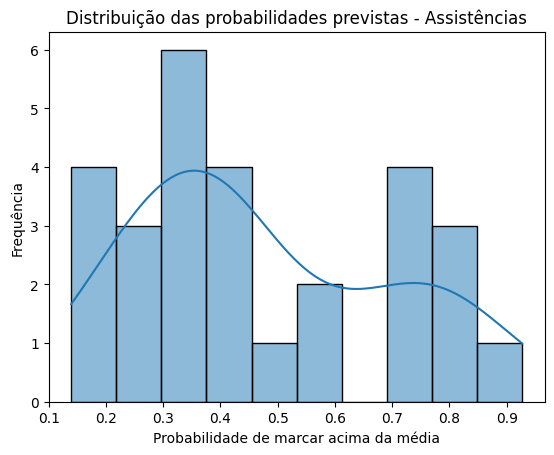

In [102]:
plotar_distribuicao_probabilidades(resultados_assistencias, 'Assistências')

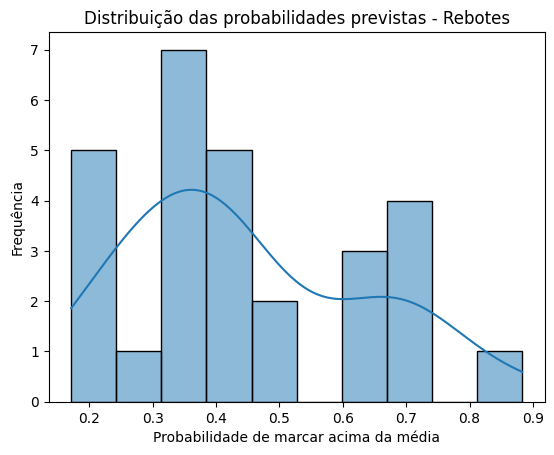

In [103]:
plotar_distribuicao_probabilidades(resultados_rebotes, 'Rebotes')

### Curva ROC

In [104]:
def plotar_curva_roc(y_teste, y_pred, estatistica_analisada):
    falsos_positivos, verdadeiros_positivos, _ = roc_curve(y_teste, y_pred)
    roc_auc = auc(falsos_positivos, verdadeiros_positivos)
    
    plt.plot(falsos_positivos, verdadeiros_positivos, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Falsos positivos')
    plt.ylabel('Verdadeiros positivos')
    plt.title(f'Curva ROC - {estatistica_analisada} acima da média')
    plt.legend()

    exportar_grafico(f'curva_roc_{estatistica_analisada}_regressao_logistica.png')

    plt.show()

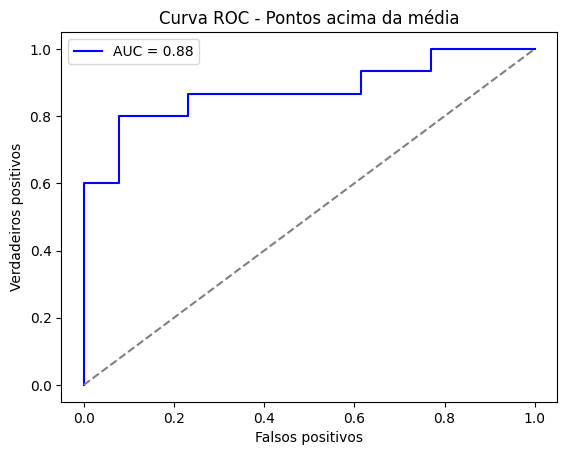

In [105]:
plotar_curva_roc(y_teste_pontos, y_prob_pontos, 'Pontos')

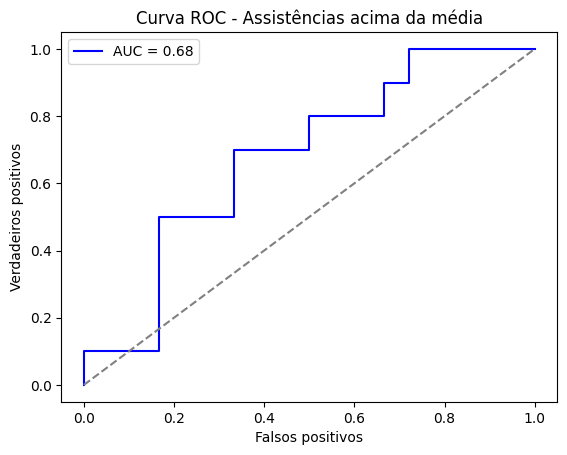

In [106]:
plotar_curva_roc(y_teste_assistencias, y_prob_assistencias, 'Assistências')

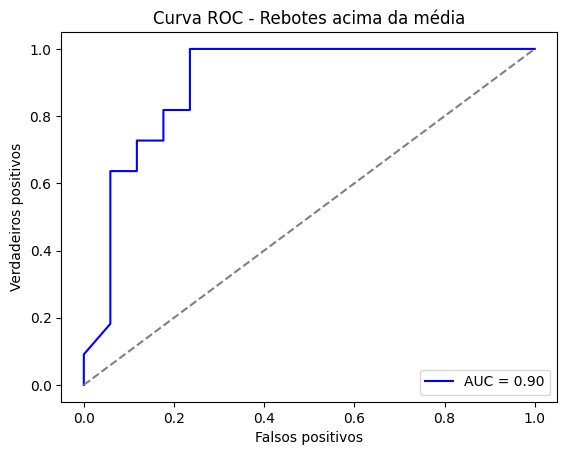

In [107]:
plotar_curva_roc(y_teste_rebotes, y_prob_rebotes, 'Rebotes')

### Gráfico de coeficientes

In [140]:
def plotar_grafico_coeficientes(modelo, X_teste, estatistica_analisada):
    coef = modelo.coef_[0]
    features = X_teste.columns

    coef_dataframe = pd.DataFrame({'Variável': features, 'Coeficiente': coef})

    coef_dataframe = coef_dataframe.sort_values(by='Coeficiente', key=np.abs, ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Coeficiente', y='Variável', hue='Variável', data=coef_dataframe, palette='coolwarm', legend=False)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.title(f'Impacto das variáveis na probabilidade de {estatistica_analisada.lower()} acima da média')
    plt.xlabel('Coeficiente da regressão logística')
    plt.ylabel('Variáveis independentes')

    exportar_grafico(f'grafico_de_coeficientes_{estatistica_analisada}_regressao_logistica.png')

    plt.show()

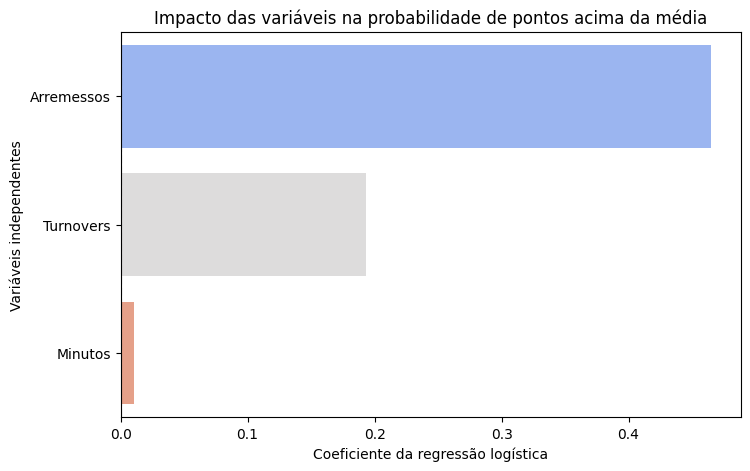

In [141]:
plotar_grafico_coeficientes(modelo_pontos, X_teste_pontos, 'Pontos')

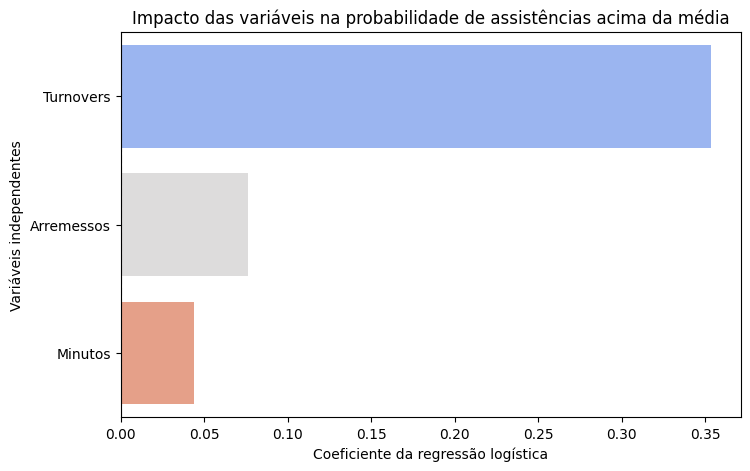

In [142]:
plotar_grafico_coeficientes(modelo_assistencias, X_teste_assistencias, 'Assistências')

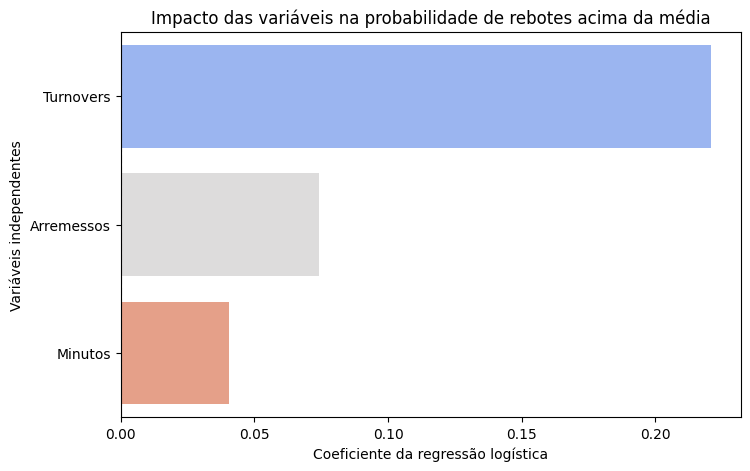

In [143]:
plotar_grafico_coeficientes(modelo_rebotes, X_teste_rebotes, 'Rebotes')